In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [18]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self._model = nn.Sequential(
            self._block(1, 20, 5),
            self._block(20, 40, 5),
            self._block(40, 100, 5, kernel_size_MaxPool2d=7),
            nn.Flatten(),
            # nn.Dropout(), # Можно попробовать изменить p
            # nn.Linear(7 * 7 * 40, 100),
            nn.Linear(100, 10)
        )

    @staticmethod
    def _block(dim_in: int, dim_out: int, kernel_size: int = 5, padding: int = 2, kernel_size_MaxPool2d=2) -> nn.Module:
        return nn.Sequential(
           nn.Conv2d(dim_in, dim_out, kernel_size, padding=padding),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=kernel_size_MaxPool2d)
        )

    def forward(self, x):
        x = self._model(x)
        return x

model_template = MnistModel()
print(model_template)

MnistModel(
  (_model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(40, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [19]:
for p in model_template.parameters():
    print(p.size())

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([40, 20, 5, 5])
torch.Size([40])
torch.Size([100, 40, 5, 5])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [5]:
num_epochs = 6
batch_size = 200
learning_rate = 0.0002
"""
Для построения кривой обучения производите измерения точности на тестовом
наборе данных через каждые 10000/«размер пакета» итераций.
10**4 - по-умолчанию
> 10**4 - для медленных обучений
"""
freq_res_output = 10**4

optimizer_func = optim.Adam

# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
train_loader_mnist = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader_mnist = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size
)

train_loader_fashion_mnist = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader_fashion_mnist = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size
)


batch size torch.Size([200, 1, 28, 28])
img size torch.Size([1, 28, 28])
tensor(8)


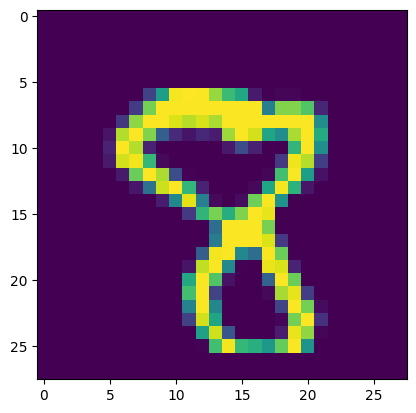

tensor(8)


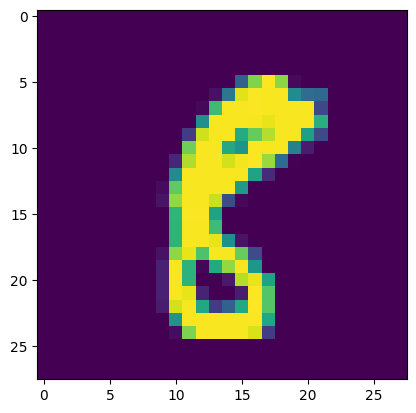

tensor(2)


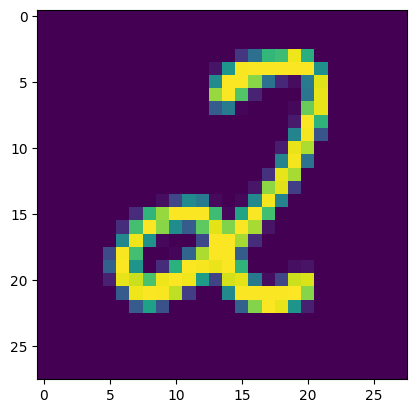

In [23]:
# img = next(train_loader)[0][0].detach().numpy()

# plt.imshow(np.transpose(img, (1,2,0)))
for batch in train_loader_mnist:
    break
    # plt.imshow(batch[0][0][0])

print('batch size', batch[0].size())
print('img size', batch[0][0].size())
for i in range(min(len(list(batch[1])), 3)):
    plt.imshow(batch[0][i][0])
    print(batch[1][i])
    plt.show()



In [22]:
def find_conv2d_layers_and_frozen_params(model, requires_grad):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            for param in layer.parameters():
                param.requires_grad = requires_grad
        elif isinstance(layer, nn.Sequential):
            find_conv2d_layers_and_frozen_params(layer, requires_grad)

def test(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            out = model(data)
            test_loss += criterion(out, target).item()
            _, predicted = torch.max(out.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100. * correct / total, test_loss / len(test_loader.dataset)


def train(model, optimizer, train_loader, test_loader, frozen_part=(-1, -1)):

    model.train()
    total_step = len(train_loader) * num_epochs
    loss_list = []
    acc_list = []

    def inner_test():
        model.eval()
        acc, loss = test(model, test_loader)
        loss_list.append((i, loss))
        acc_list.append((i, acc))
        model.train()

        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}, Accuracy: {:.2f}%'
              .format(epoch, num_epochs, i, total_step, loss, acc)
        )

    i = 0
    for epoch in range(1, num_epochs + 1):
        if frozen_part[0] <= epoch / num_epochs <= frozen_part[1]:
            frozen_text = "На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои."
            find_conv2d_layers_and_frozen_params(model, False)
        else:
            frozen_text = "На этой эпохе разморожены все conv2d слои."
            find_conv2d_layers_and_frozen_params(model, True)
        print(f"Начинаем эпоху номер {epoch}. {frozen_text}")
        for i, (data, target) in enumerate(train_loader, start=i+1):
            outputs = model(data)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % (freq_res_output // batch_size) == 0: # Выводить результат каждую 10**4 / batch_size итерацию
                inner_test()

    if i % (freq_res_output // batch_size) != 0:
        inner_test()

    return loss_list, acc_list

In [23]:
def plot_loss_and_acc(loss_list, acc_list, step = len(train_loader_mnist), max_step =len(train_loader_mnist) * num_epochs):
    loss_iter, loss_list = zip(*loss_list)
    acc_iter, acc_list = zip(*acc_list)

    for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
    plt.plot(loss_iter, loss_list)
    plt.title("График эмпирического риска")
    plt.xlabel("Итерация")
    plt.ylabel("Loss")
    plt.show()

    for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
    plt.plot(acc_iter, acc_list)
    plt.title("График качества")
    plt.xlabel("Итерация")
    plt.ylabel("Точность в процентах")
    plt.show()


## Пункт 1
Придумайте архитектуру свёрточной сети для решения задачи классификации
на наборе данных MNIST. Обучите и протестируйте её. Постройте кривую
обучения. Сохраните полученные параметры.

In [24]:
model1 = MnistModel()
optimizer1 = optimizer_func(model1.parameters(), lr=learning_rate)
loss_list1, acc_list1 = train(model1, optimizer1, train_loader_mnist, test_loader_mnist)

Начинаем эпоху номер 1. На этой эпохе разморожены все conv2d слои.
Epoch [1/6], Step [50/1800], Loss: 0.008508, Accuracy: 77.04%
Epoch [1/6], Step [100/1800], Loss: 0.002960, Accuracy: 86.14%
Epoch [1/6], Step [150/1800], Loss: 0.001695, Accuracy: 91.75%
Epoch [1/6], Step [200/1800], Loss: 0.001300, Accuracy: 92.82%
Epoch [1/6], Step [250/1800], Loss: 0.001113, Accuracy: 93.91%
Epoch [1/6], Step [300/1800], Loss: 0.000972, Accuracy: 94.26%
Начинаем эпоху номер 2. На этой эпохе разморожены все conv2d слои.
Epoch [2/6], Step [350/1800], Loss: 0.000880, Accuracy: 95.05%
Epoch [2/6], Step [400/1800], Loss: 0.000766, Accuracy: 95.32%
Epoch [2/6], Step [450/1800], Loss: 0.000883, Accuracy: 94.56%
Epoch [2/6], Step [500/1800], Loss: 0.000657, Accuracy: 95.76%
Epoch [2/6], Step [550/1800], Loss: 0.000636, Accuracy: 96.02%
Epoch [2/6], Step [600/1800], Loss: 0.000589, Accuracy: 96.43%
Начинаем эпоху номер 3. На этой эпохе разморожены все conv2d слои.
Epoch [3/6], Step [650/1800], Loss: 0.000582

In [25]:
# Сохраняем модель для будущих пунктов
filepath_model1 = "model1.save"
torch.save(model1.state_dict(), filepath_model1)

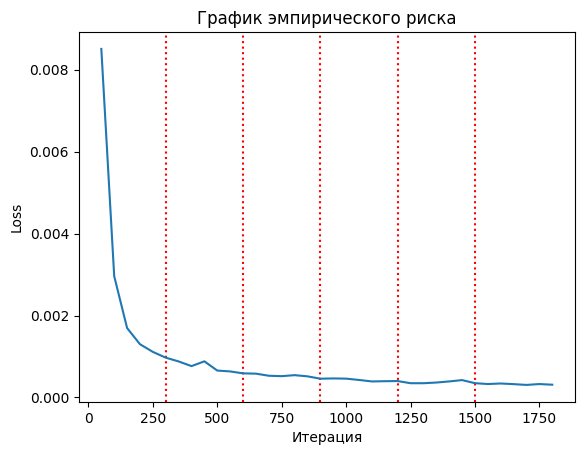

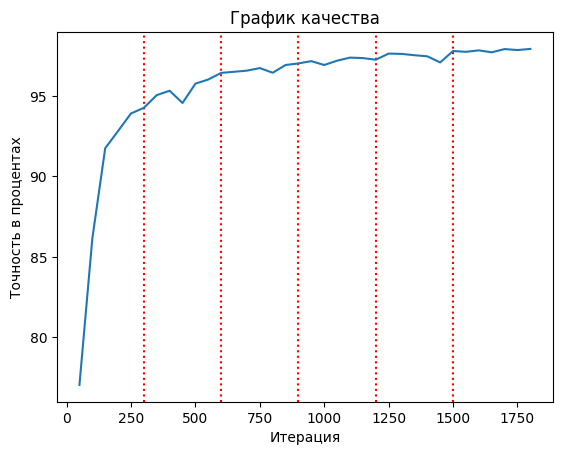

In [26]:
plot_loss_and_acc(loss_list1, acc_list1)

## Пункт 2
Обучите и протестируйте ту же самую архитектуру на наборе данных
Fashion-MNIST. Постройте кривую обучения.


In [27]:
model2 = MnistModel()
optimizer2 = optimizer_func(model2.parameters(), lr = 5 * learning_rate)
loss_list2, acc_list2 = train(model2, optimizer2, train_loader_fashion_mnist, test_loader_fashion_mnist)

Начинаем эпоху номер 1. На этой эпохе разморожены все conv2d слои.
Epoch [1/6], Step [50/1800], Loss: 0.003978, Accuracy: 68.97%
Epoch [1/6], Step [100/1800], Loss: 0.003298, Accuracy: 74.86%
Epoch [1/6], Step [150/1800], Loss: 0.002880, Accuracy: 78.88%
Epoch [1/6], Step [200/1800], Loss: 0.002655, Accuracy: 80.87%
Epoch [1/6], Step [250/1800], Loss: 0.002476, Accuracy: 81.58%
Epoch [1/6], Step [300/1800], Loss: 0.002552, Accuracy: 81.47%
Начинаем эпоху номер 2. На этой эпохе разморожены все conv2d слои.
Epoch [2/6], Step [350/1800], Loss: 0.002348, Accuracy: 83.53%
Epoch [2/6], Step [400/1800], Loss: 0.002150, Accuracy: 84.51%
Epoch [2/6], Step [450/1800], Loss: 0.002195, Accuracy: 84.00%
Epoch [2/6], Step [500/1800], Loss: 0.002086, Accuracy: 85.06%
Epoch [2/6], Step [550/1800], Loss: 0.002101, Accuracy: 85.41%
Epoch [2/6], Step [600/1800], Loss: 0.001979, Accuracy: 85.64%
Начинаем эпоху номер 3. На этой эпохе разморожены все conv2d слои.
Epoch [3/6], Step [650/1800], Loss: 0.001974

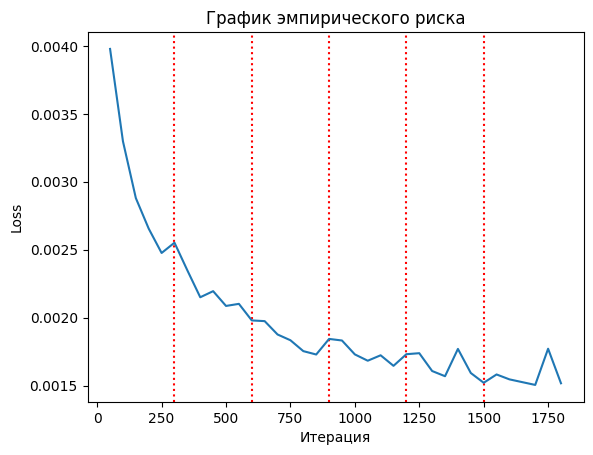

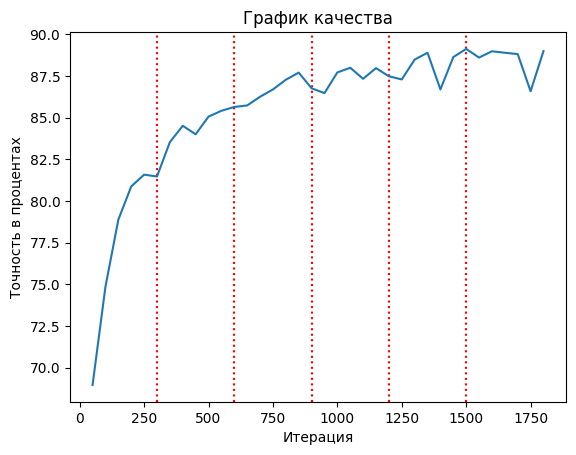

In [28]:
plot_loss_and_acc(loss_list2, acc_list2)

## Пункт 3
Повторите предыдущий эксперимент, но начните обучения не со случайных
параметров, а с сохранённых в первом пункте.

In [29]:
model3 = MnistModel()
model3.load_state_dict(torch.load(filepath_model1))
optimizer3 = optimizer_func(model3.parameters(), lr = 5 * learning_rate)
loss_list3, acc_list3 = train(model3, optimizer3, train_loader_fashion_mnist, test_loader_fashion_mnist)

Начинаем эпоху номер 1. На этой эпохе разморожены все conv2d слои.
Epoch [1/6], Step [50/1800], Loss: 0.004243, Accuracy: 70.64%
Epoch [1/6], Step [100/1800], Loss: 0.003491, Accuracy: 73.97%
Epoch [1/6], Step [150/1800], Loss: 0.003010, Accuracy: 78.70%
Epoch [1/6], Step [200/1800], Loss: 0.002782, Accuracy: 80.47%
Epoch [1/6], Step [250/1800], Loss: 0.002633, Accuracy: 81.81%
Epoch [1/6], Step [300/1800], Loss: 0.002525, Accuracy: 82.11%
Начинаем эпоху номер 2. На этой эпохе разморожены все conv2d слои.
Epoch [2/6], Step [350/1800], Loss: 0.002383, Accuracy: 83.72%
Epoch [2/6], Step [400/1800], Loss: 0.002497, Accuracy: 83.12%
Epoch [2/6], Step [450/1800], Loss: 0.002464, Accuracy: 82.06%
Epoch [2/6], Step [500/1800], Loss: 0.002164, Accuracy: 84.83%
Epoch [2/6], Step [550/1800], Loss: 0.002153, Accuracy: 85.03%
Epoch [2/6], Step [600/1800], Loss: 0.002553, Accuracy: 82.44%
Начинаем эпоху номер 3. На этой эпохе разморожены все conv2d слои.
Epoch [3/6], Step [650/1800], Loss: 0.002036

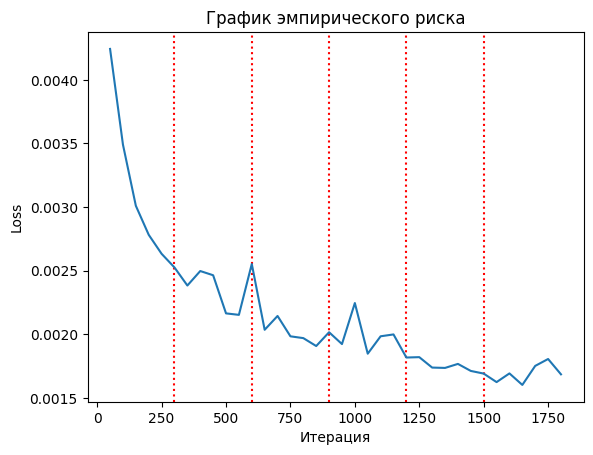

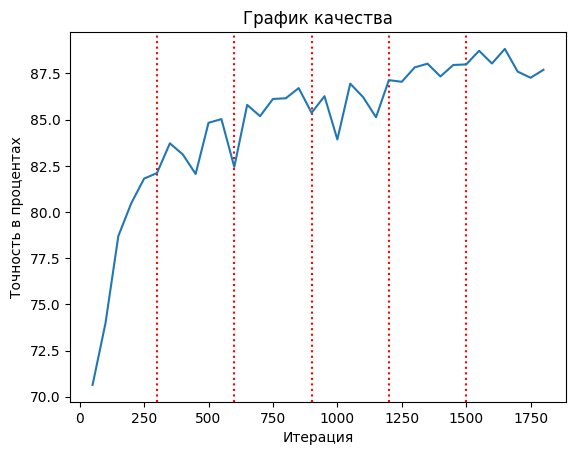

In [30]:
plot_loss_and_acc(loss_list3, acc_list3)

## Пункт 4
Повторите предыдущий эксперимент, но заморозьте параметры на свёрточных
слоях.

In [31]:
model4 = MnistModel()
model4.load_state_dict(torch.load(filepath_model1))
optimizer4 = optimizer_func(model4.parameters(), lr = 5 * learning_rate)
loss_list4, acc_list4 = train(model4, optimizer4, train_loader_fashion_mnist, test_loader_fashion_mnist, frozen_part=(0, 1))

Начинаем эпоху номер 1. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [1/6], Step [50/1800], Loss: 0.013370, Accuracy: 27.72%
Epoch [1/6], Step [100/1800], Loss: 0.009610, Accuracy: 37.59%
Epoch [1/6], Step [150/1800], Loss: 0.007385, Accuracy: 47.68%
Epoch [1/6], Step [200/1800], Loss: 0.006283, Accuracy: 55.52%
Epoch [1/6], Step [250/1800], Loss: 0.005565, Accuracy: 60.23%
Epoch [1/6], Step [300/1800], Loss: 0.005344, Accuracy: 60.79%
Начинаем эпоху номер 2. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [2/6], Step [350/1800], Loss: 0.004922, Accuracy: 63.99%
Epoch [2/6], Step [400/1800], Loss: 0.004729, Accuracy: 65.99%
Epoch [2/6], Step [450/1800], Loss: 0.004606, Accuracy: 66.51%
Epoch [2/6], Step [500/1800], Loss: 0.004485, Accuracy: 67.09%
Epoch [2/6], Step [550/1800], Loss: 0.004323, Accuracy: 68.12%
Epoch [2/6], Step [600/1800], Loss: 0.004249, Accuracy: 68.77%
Начинаем эпоху номер 3. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [3/6], Step [650/1800], Loss: 0.004065, A

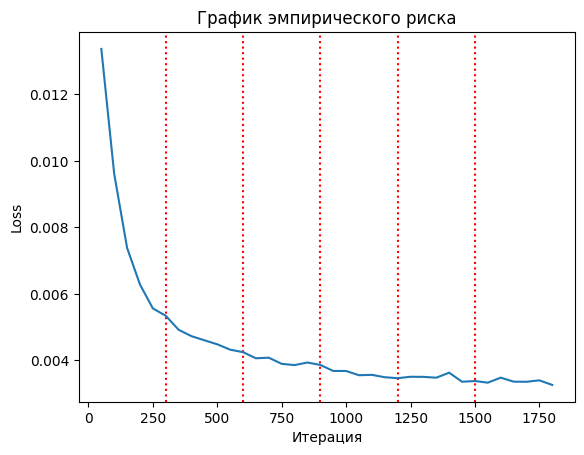

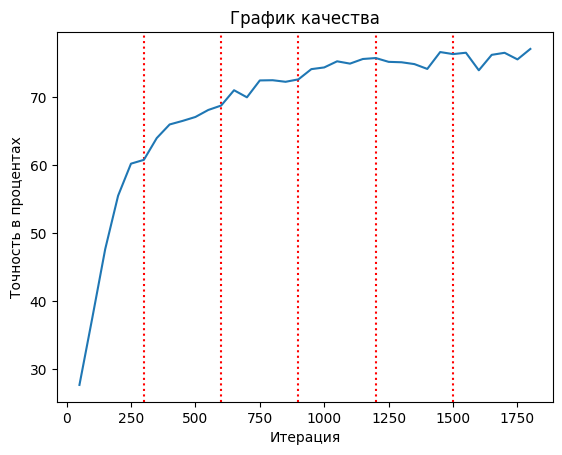

In [32]:
plot_loss_and_acc(loss_list4, acc_list4)

## Пункт 5
Повторите предыдущий эксперимент, но после нескольких эпох разморозьте и
дообучите параметры.

In [33]:
model5 = MnistModel()
model5.load_state_dict(torch.load(filepath_model1))
optimizer5 = optimizer_func(model5.parameters(), lr = 5 * learning_rate)
loss_list5, acc_list5 = train(model5, optimizer5, train_loader_fashion_mnist, test_loader_fashion_mnist, frozen_part=(0, 0.5))

Начинаем эпоху номер 1. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [1/6], Step [50/1800], Loss: 0.013331, Accuracy: 26.13%
Epoch [1/6], Step [100/1800], Loss: 0.009639, Accuracy: 37.19%
Epoch [1/6], Step [150/1800], Loss: 0.007279, Accuracy: 48.32%
Epoch [1/6], Step [200/1800], Loss: 0.006121, Accuracy: 56.81%
Epoch [1/6], Step [250/1800], Loss: 0.005493, Accuracy: 60.47%
Epoch [1/6], Step [300/1800], Loss: 0.005228, Accuracy: 62.84%
Начинаем эпоху номер 2. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [2/6], Step [350/1800], Loss: 0.005100, Accuracy: 63.85%
Epoch [2/6], Step [400/1800], Loss: 0.004677, Accuracy: 65.10%
Epoch [2/6], Step [450/1800], Loss: 0.004548, Accuracy: 66.50%
Epoch [2/6], Step [500/1800], Loss: 0.004627, Accuracy: 66.88%
Epoch [2/6], Step [550/1800], Loss: 0.004329, Accuracy: 68.29%
Epoch [2/6], Step [600/1800], Loss: 0.004146, Accuracy: 70.20%
Начинаем эпоху номер 3. На этой эпохе ЗАМОРОЖЕНЫ все conv2d слои.
Epoch [3/6], Step [650/1800], Loss: 0.004161, A

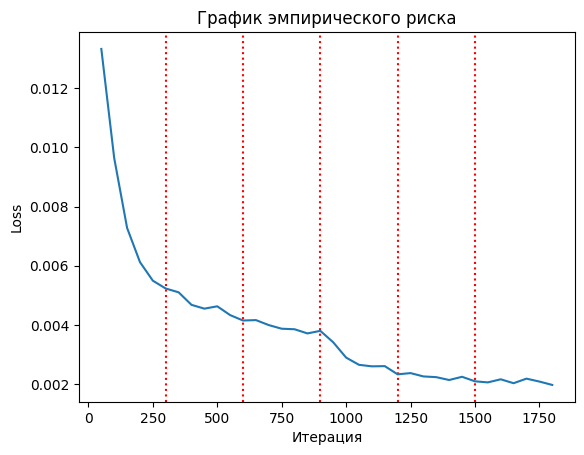

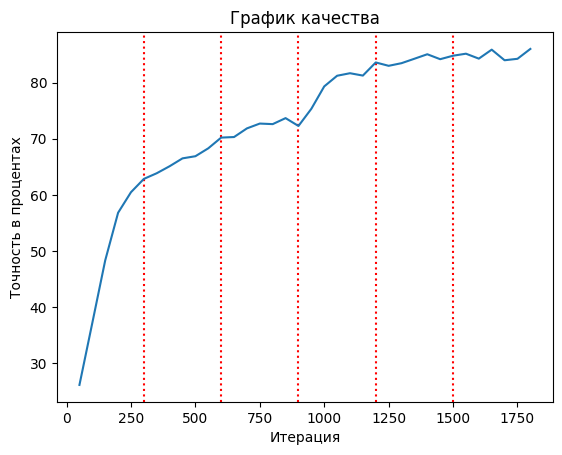

In [34]:
plot_loss_and_acc(loss_list5, acc_list5)

# Итоги
Построим график, объединяющий все остальные графики

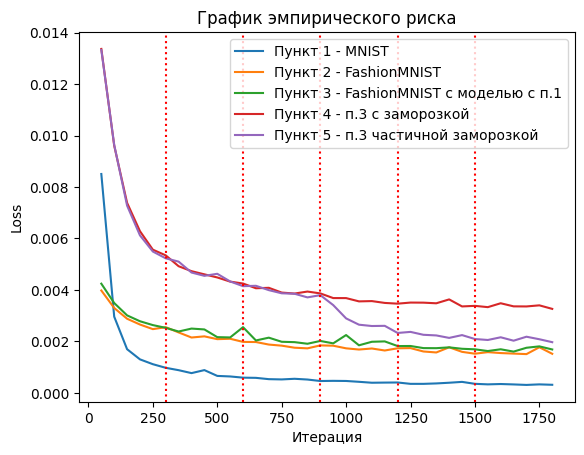

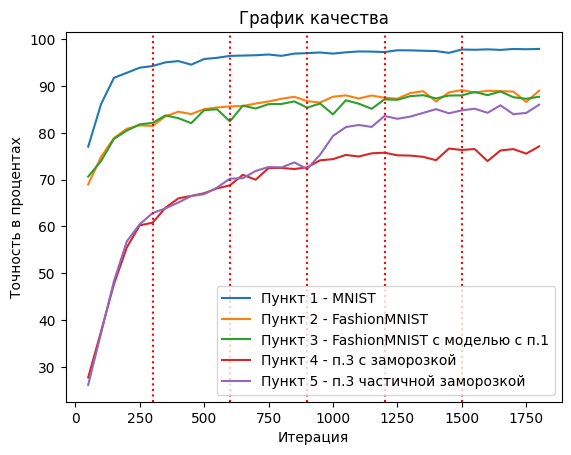

In [36]:
# def plot_loss_and_acc(loss_list, acc_list, step = len(train_loader_mnist), max_step =len(train_loader_mnist) * num_epochs):
#     loss_iter, loss_list = zip(*loss_list)
#     acc_iter, acc_list = zip(*acc_list)
#
#     for x in range(step, max_step, step):
#         plt.axvline(x=x, linestyle=':', color='r')
#     plt.plot(loss_iter, loss_list)
#     plt.title("График эмпирического риска")
#     plt.xlabel("Итерация")
#     plt.ylabel("Loss")
#     plt.show()
#
#     for x in range(step, max_step, step):
#         plt.axvline(x=x, linestyle=':', color='r')
#     plt.plot(acc_iter, acc_list)
#     plt.title("График качества")
#     plt.xlabel("Итерация")
#     plt.ylabel("Точность в процентах")
#     plt.show()

def plot_list(_list):
    _iter, _list = zip(*_list)
    plt.plot(_iter, _list)

step = len(train_loader_mnist)
max_step =len(train_loader_mnist) * num_epochs

for l in (
    loss_list1,
    loss_list2,
    loss_list3,
    loss_list4,
    loss_list5,
):
    plot_list(l)
legend = (
    "Пункт 1 - MNIST",
    "Пункт 2 - FashionMNIST",
    "Пункт 3 - FashionMNIST с моделью с п.1",
    "Пункт 4 - п.3 с заморозкой",
    "Пункт 5 - п.3 с частичной заморозкой",
)
plt.legend(legend)
for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
plt.title("График эмпирического риска")
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.show()


for l in (
    acc_list1,
    acc_list2,
    acc_list3,
    acc_list4,
    acc_list5,
):
    plot_list(l)
plt.legend(legend)
for x in range(step, max_step, step):
        plt.axvline(x=x, linestyle=':', color='r')
plt.title("График качества")
plt.xlabel("Итерация")
plt.ylabel("Точность в процентах")
plt.show()